<a href="https://colab.research.google.com/github/DonRoboto/ReinforcemenLearning_v1/blob/main/OPTIMIZACI%C3%93N_DE_HIPERPAR%C3%81METROS_PRESENTACI%C3%93N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero se exportan librerias y modulos que se utilizaran.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import set_random_seed


from tensorflow.keras.optimizers import Adam



Damos acceso a colab a Drive.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se crea un programa para generar las entradas y salidas de la red LSTM.

In [ ]:

class CreateDataset:
    """
    Este programa preprocesa los datos.
    """

    def __init__(self, path) -> None:

        self.path = path        
        self.df = pd.read_csv(path, index_col = 'Date', parse_dates=True)

        self.df_all = self.df
        self.normalize()

    def normalize(self):
        """
        Este méotodo hace una normalización de los datos.
        """
        self.scaler = MinMaxScaler()
        values = self.df.loc[:,['Close']].values
        self.scaler.fit(np.array(values))
        self.df = self.scaler.transform(values)

        self.do_scale_close()


    def do_scale_close(self):
        """
        Normaliza el precio de cierre.
        """
        self.scale_close = MinMaxScaler(feature_range=(0, 1))
        values = self.df_all['Close'].values.reshape(-1, 1)
        self.scale_close.fit(values)
        self.close = self.scale_close.transform(values).reshape(-1)

    def create_dataset(self, dataset1, dataset2, windows=0):
        """
        Crea el conjunto de datos. 
        """
        dataX, dataY = [], []
        for i in range(len(dataset1) - windows   -1):  
            a = dataset1[i:(i + windows)]
            dataX.append(a)
            dataY.append(dataset2[i + windows])    
        return np.array(dataX), np.array(dataY)
    
    def crea_all_dataset(self, windows=100, train_size=0.65):
        """
        Corre cada uno de los métodos para geberar las entradas y salidas.
        """
        
        training_size = int(len(self.df)*train_size)
        train_data_x, test_data_x = self.df[:training_size], self.df[training_size:]
        train_data_y, test_data_y = self.close[:training_size], self.close[training_size:]
        self.X_train, self.y_train = self.create_dataset(train_data_x, train_data_y, windows)
        self.X_test, self.y_test = self.create_dataset(test_data_x, test_data_y, windows)

        self.X_train = self.X_train
        self.X_test = self.X_test

In [ ]:

path = 'GOOGL.csv'
train_size = 0.85
seed = 1



batch_size = [8, 16, 32, 64]
epochs_list = [12, 25, 50, 100, 150]
hidden_list = [1, 20, 50, 80, 96, 110, 150]
windows_list = [20, 40, 60, 80, 90, 100]

no_filters = [1, 20, 50, 80, 96, 110, 150]
# kernel_size_space = [1, 2, 3, 4, 5]
kernel_size_space = [1, 20, 50, 80, 96]

create_dataset = CreateDataset(path=path)


In [ ]:


class Problem:
    def __init__(self, save_solitions, seed) -> None:
        set_random_seed(seed=seed)
        self.SOLUTIONS_LIST = list()
        self.FITNESS_LIST = list()
        self.solutions_path = save_solitions
        try:
            self.load_solutions()
        except:            
            with open(self.solutions_path, 'w') as fp:  
                print("Created file for to save solutions and fitness")


    def save_solution_fitness_to_csv(self, solution, fitness):
        """
        Guardar soluciones, este método sirve para guardar soluciones
        de cada llamada a función,
        este método ayuda para detener el programa
        y luego continuar con el proceso de optimización 
        cargando las solucioens guarddas hasta ese momento.

        """
        with open(self.solutions_path, 'a') as fp:
            writer = csv.writer(fp)
            writer.writerow([[solution], fitness])

    def load_solutions(self):
        """
        Este método carga soluciones.
        
        """
        
        with open(self.solutions_path, 'r') as fp:    
            writer = csv.reader(fp)
            l1 = list(writer)
            for sf in l1:
                fitness = float(sf[1])     
                self.FITNESS_LIST.append(fitness)  

                solution = sf[0].replace('[', '').replace(']', '').split(',')
                solution = list(map(int, solution))

                self.SOLUTIONS_LIST.append(solution)
            print("Se cargaron soluciones.")
   
   
    def create_ann(self,
            hidden_states: int,
            windows: int,
            optimizer: str,
            batch_size: int,
            epochs: int,
            n_layers: int):
        """
        Crea red neuronal tipo LSTM con los hiperparámetros dados.
        """
        
        

        self.epochs = epochs # Guardo el número de épocas. 
        
        self.model = Sequential() # Instancia un modelo secuencial.

        
        # Con las siguientes funciones creo la red LSTM, en caso de ser mayor a uno n_layer, crea una red
        # con más de una celda LSTM.
        if n_layers > 1:
            # Crea una red con varias celdas LSTM
            # Cuando tiene más de una celdas, las celdas LSTM deben de tener return_sequences en True, para retornar toda la secuencia.
            # input_shape=(windows, 1) se refiere al tamaño de la secuencia y el número de característica de la sequencia. (windows, 1 por que solo entra el precio de cierre)
            self.model.add(LSTM(hidden_states, return_sequences=True, input_shape=(windows, 1))) 
            self.model.add(Dropout(0.5))
            for _ in range(2, n_layers):
                self.model.add(LSTM(hidden_states, return_sequences=True, input_shape=(windows, 1)))
                self.model.add(Dropout(0.5))
            self.model.add(LSTM(hidden_states, return_sequences=False, input_shape=(windows, 1)))
            self.model.add(Dropout(0.5))
        else: # De lo contrario crea una red LSTM con una sola celda. 
            # Crea una red neuronal con una sola celda LSTM
            self.model.add(LSTM(hidden_states, return_sequences=False, input_shape=(windows, 1)))
            self.model.add(Dropout(0.5))
        self.model.add(Dense(1))

        # Se compila el modelo.        
        self.model.compile(loss='mean_squared_error', optimizer=optimizer)
        
        self.batch_size = batch_size

    

    def trian_ann(self, solution_vector):
        # hidden, windwos, learning_rate, batch, epochs, n_layers
        #    0       1         2             3       4        5  

        hidden = hidden_list[int(np.round(solution_vector[0]))] # Los valores los tomo como indices del despacio de búsqueda.

        windows = windows_list[int(np.round(solution_vector[1]))]

        lr = int(np.round(solution_vector[2]))

        learning_rate = float(f'1e-{lr}') # El vector que toma son números enterios que solo lo cambio añadiendo el número como se muestra aquí 1e-2

        batch = batch_size[int(np.round(solution_vector[3]))]

        epochs = epochs_list[int(np.round(solution_vector[4]))]

        n_layers = int(np.round(solution_vector[5])) # En este caso el espacio de búsqueda si es el número de celdas y no se usa como indice.
       
        solution_vector_2 = [hidden, windows, lr, batch, epochs, n_layers]

        if solution_vector_2 in self.SOLUTIONS_LIST: # Reviso si la solución ya ha sido evaluada, entonces solo la retorno
            idx = self.SOLUTIONS_LIST.index(solution_vector_2)
            return self.FITNESS_LIST[idx]
        else: # De lo contrario guardo la solución y comienso con el entrenamiento.
            self.SOLUTIONS_LIST.append(solution_vector_2)
            
            optimizer = Adam(learning_rate=learning_rate) 
            
        

            # Creae una red neuronal con los hierparametros dados por solution_vector
            self.create_ann(
                    hidden_states=hidden,
                    windows=windows,
                    optimizer=optimizer,
                    batch_size=batch,
                    epochs=epochs,
                    n_layers=n_layers)

            # Crea el conjunto de entrenamiento y prueba usando usando una ventana 
            create_dataset.crea_all_dataset(windows=windows, train_size=train_size) 


            # Toma los valores creados de entrenamiento y de prueba
            X_train = create_dataset.X_train
            y_train = create_dataset.y_train




            # Entrena el modelo
            self.train_model(
                X_train=X_train,
                y_train=y_train,
                verbose=0
            )


            #    test_predict_scaled
            self.FITNESS_LIST.append(self.score)
            self.save_solution_fitness_to_csv(solution_vector_2, self.score) # Guardamos la soluciòn y su fitness (valor de pérdida de la red LSTM)
            return self.score # Retorna el fitness (valor de pérdida de la red LSTM)

    def train_model(
            self,
            X_train,
            y_train,
            verbose=0):

        # Con esto creo un conjunto de datos para entrenamiento y otro de validacion.
        n = int(len(X_train) *.76)

        X_test = X_train[n:] # No debe decir test, debe decir validation.
        y_test = y_train[n:] # No debe decir test, debe decir validation.

        X_train = X_train[:n]
        y_train = y_train[:n]


        early_stopping_loss = EarlyStopping(monitor='loss', patience=5)
        early_stopping_val_loss = EarlyStopping(monitor="val_loss", patience=5)
        callbacks = [early_stopping_loss, early_stopping_val_loss]

        

        self.history = self.model.fit(
                    X_train,
                    y_train,
                    epochs=self.epochs,
                    validation_data=(X_test, y_test),
                    batch_size=self.batch_size,
                    verbose=verbose,
                    callbacks=callbacks)



        self.score = self.history.history['loss'][-1]
        del self.model

    
    def __call__(self, solution_vector):
        return self.train_each_particle(solution_vector)
        


    def train_each_particle(self, solution_vector):
        return np.array(list(map(self.trian_ann, solution_vector)))

    

In [ ]:
# Documentation:
# https://pyswarms.readthedocs.io/en/latest/installation.html
!pip install pyswarms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104 kB 28.6 MB/s 


In [ ]:
import pyswarms as ps

import csv



def run():
    assert len(limit_min) == len(limit_max)
    np.random.seed(seed)

    # Intancia modelo
    optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=len(limit_min),
        options=options, bounds=bounds)

    # Reliza optimización
    stats = optimizer.optimize(problem, iters=iters)


if __name__ == '__main__':
    seed = 4 # Semilla de inicio de números aleatorios
    # Ruta de soluciones guardadas junto con su valor fitness.
    path = 'soutions_and_fitness.csv'
    
    problem = Problem(save_solitions=path, seed=seed)

    iters = 16 # número de iteraciones.
    n_particles = 25 # número de particulas
    verbose = False # Para imprimir información de partícula cada 100 iteraciones.
    w = 0.8 # Inercia
    c1 = 0.6 # Coeficiente de aceleración de parte cognitiva
    c2 = 0.8 # Coeficiente de aceleración de parte social
    # Coeficiente de construcción
    options = {'c1': c1, 'c2': c2, 'w': w}
    # use_co_constr = True # Si este valor es verdadero en automatico se ejecuta c1=c2=2.05

    # hidden, windwos, learning_rate, batch, epochs, n_layers
    #    0       1         2             3       4        5  
    limit_min = [0, 0, 1, 0, 0, 1] # Orientar con las diapositivas
    #            0  1  2  3  4  5
    limit_max = [6, 5, 5, 3, 4, 8]
    bounds = (limit_min, limit_max)
    run()


2022-09-30 22:36:08,403 - pyswarms.single.global_best - INFO - Optimize for 16 iters with {'c1': 0.6, 'c2': 0.8, 'w': 0.8}


Created file for to save solutions and fitness


pyswarms.single.global_best:   0%|          |0/16

In [ ]:
def print_solution(*solution_vector):
    # hidden, windwos, learning_rate, batch, epochs, n_layers, 
    #    0       1         2             3       4        5    
    batch_size = [8, 16, 32, 64]
    epochs_list = [12, 25, 50, 100, 150]
    hidden_list = [1, 20, 50, 80, 96, 110, 150]
    windows_list = [20, 40, 60, 80, 90, 100]


    # Instancia el optimizador con un learning rate dado.
    lr = int(np.round(solution_vector[2]))
    learning_rate = float(f'1e-{lr}')
    hidden = int(np.round(solution_vector[0]))
    windows = int(np.round(solution_vector[1]))
    batch = int(np.round(solution_vector[3]))
    epochs = int(np.round(solution_vector[4]))


  
    print("Cells:         ", int(np.round(solution_vector[5])))
    print("Hiddens:       ", hidden_list[hidden])
    print("Learning rate: ", learning_rate)
    print("Windows:       ", windows_list[windows])       
    print("Batch:         ", batch_size[batch])
    print("Epochs:        ", epochs_list[epochs])

solution_google_pso = [5.83984759, 4.41877349, 3.07672751, 1.87874572, 2.70462338, 1.45628355]
print("Usando PSO")
print("Caso de GOOGLE.")
print_solution(*solution_google_pso)

Usando PSO
Caso de GOOGLE.
Cells:          1
Hiddens:        150
Learning rate:  0.001
Windows:        90
Batch:          32
Epochs:         100


In [ ]:

path = 'GOOGL.csv'
hidden_states = 150

learning_rate = 1e-3
windows = 90
batch_size = 32
epochs = 100

optimizer = Adam(learning_rate=learning_rate)

verbose = True # Si está en True se muestra la información de entrenamiento de la red
create_dataset = CreateDataset(path=path)
create_dataset.crea_all_dataset(windows=windows,train_size=0.85) 
X_train = create_dataset.X_train
y_train = create_dataset.y_train
X_test = create_dataset.X_test
y_test = create_dataset.y_test

In [ ]:
early_stopping_loss = EarlyStopping(monitor='loss', patience=5)
early_stopping_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callbacks = [early_stopping_loss, early_stopping_val_loss]

In [ ]:

model = Sequential()

model.add(LSTM(hidden_states, return_sequences=False, input_shape=(windows, 1)))
model.add(Dropout(0.5))

model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               91200     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="mse", optimizer=optimizer)
n = int(len(X_train) *.76)
history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,

            )


Epoch 1/100
114/114 [==============================] - 7s 8ms/step - loss: 0.0012
Epoch 2/100
114/114 [==============================] - 1s 8ms/step - loss: 3.6166e-04
Epoch 3/100
114/114 [==============================] - 1s 8ms/step - loss: 3.2978e-04
Epoch 4/100
114/114 [==============================] - 1s 8ms/step - loss: 3.1771e-04
Epoch 5/100
114/114 [==============================] - 1s 8ms/step - loss: 2.4206e-04
Epoch 6/100
114/114 [==============================] - 1s 8ms/step - loss: 2.0931e-04
Epoch 7/100
114/114 [==============================] - 1s 7ms/step - loss: 2.0978e-04
Epoch 8/100
114/114 [==============================] - 1s 7ms/step - loss: 2.2595e-04
Epoch 9/100
114/114 [==============================] - 1s 7ms/step - loss: 1.9482e-04
Epoch 10/100
114/114 [==============================] - 1s 8ms/step - loss: 1.5438e-04
Epoch 11/100
114/114 [==============================] - 1s 8ms/step - loss: 1.5686e-04
Epoch 12/100
114/114 [==============================] - 

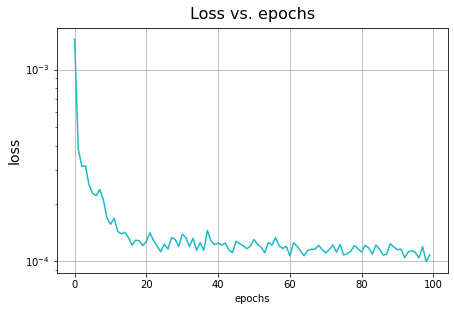

In [ ]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'14'}
plt.figure(figsize=(7, 4.5))
plt.plot(history.history['loss'], color="#1CBBC4")
plt.title('Loss vs. epochs', **title_font)
plt.ylabel('loss',  **axis_font)
plt.xlabel('epochs')
plt.grid(True)
# plt.xticks(np.arange(len(history_loss_array)), np.arange(1, len(history_loss_array)+1))
plt.yscale('log')
# plt.savefig('IMAGE_EXPERIMENTS/loss_CNN-LSTM.jpg')
plt.show()

In [ ]:
def axis(date, windows):
    dataX = []
    for i in range(len(date) - windows   -1):
        dataX.append(date[i + windows])    
    return np.array(dataX)

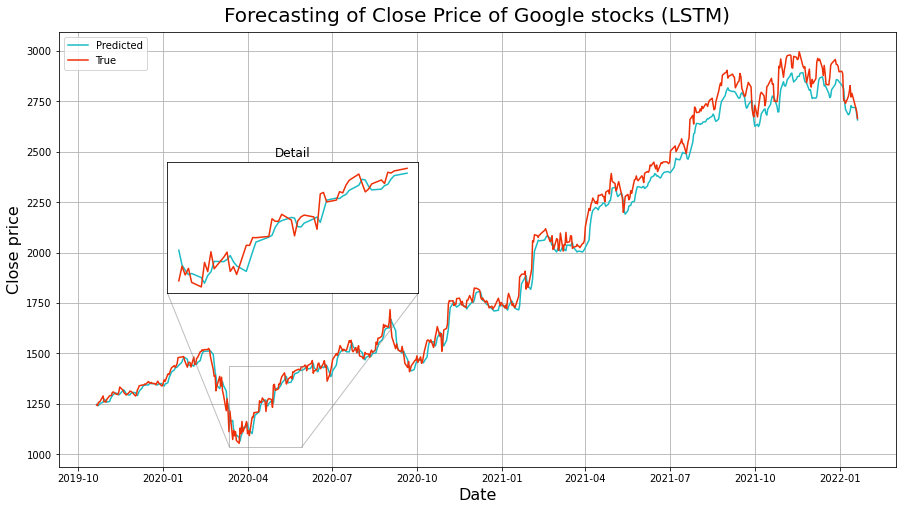

In [ ]:
shape = X_test.shape

X_test = X_test.reshape((shape[0], shape[1], shape[2]))
X_test.shape
y_predict = model.predict(X_test)
y_predict.shape, y_test.shape
y_predict = create_dataset.scale_close.inverse_transform(y_predict)
y_test = create_dataset.scale_close.inverse_transform(y_test.reshape(1,-1)).reshape(-1)

axis_x = create_dataset.df_all.index

training_size = int(len(axis_x)*0.85) 
axis_x_train, axis_x_test = axis_x[0:training_size], axis_x[training_size:len(axis_x)]
axis_x_test = axis(axis_x_test, windows)
axis_x_train = axis(axis_x_train, windows)

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'16'}

font = {'size': 15} 
fig, ax= plt.subplots(figsize=(15, 8))

# ax.imshow(Z2, extent=extent, origin="lower")
ax.plot(axis_x_test, y_predict.reshape(-1), label='Predicted', color="#1CBBC4")
ax.plot(axis_x_test, y_test.reshape(-1), label='True', color="#ED3007")
ax.set_title("Forecasting of Close Price of Google stocks (LSTM)", **title_font)


axins = ax.inset_axes([0.13, 0.4, 0.3, 0.3])
axins.set_title('Detail')
axins.plot(axis_x_test[100:150], y_predict[100:150], label='True', color="#1CBBC4")
axins.plot(axis_x_test[100:150], y_test[100:150], label='True', color="#ED3007")
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
ax.indicate_inset_zoom(axins, label='')


ax.set_xlabel('Date', **axis_font)
ax.set_ylabel('Close price', **axis_font)



ax.legend()
ax.grid()
# plt.savefig('IMAGE_EXPERIMENTS/predicts_CNN-LSTM.jpg')
plt.show()